# Introduction to Overpass API and OpenStreetMap for Enriching Traffic Accident Data

## What is OpenStreetMap (OSM)?

**OpenStreetMap (OSM)** is a collaborative, open-source project that provides freely accessible geographic data of the world. It is maintained and edited by a community of volunteers and contains detailed information about roads, buildings, amenities (like schools and hospitals), transportation infrastructure, and more.

## What is the Overpass API?

The **Overpass API** is a powerful tool designed to query data from the OpenStreetMap database. Instead of downloading the entire OSM dataset, Overpass allows you to request specific elements based on conditions such as type of feature, location, or proximity.

Overpass API supports complex queries using its own query language, **Overpass QL**, which allows users to fetch:

- Specific types of features (e.g., `amenity=school`)
- Elements within a bounding box or a radius from a point
- Features within administrative areas (e.g., cities or counties)

## Use Case in This Project

This project focuses on enriching a dataset of traffic accidents in the United States by adding geospatial context from OpenStreetMap using the Overpass API.

We defined bounding boxes for **20 major cities** in the U.S. and retrieved OSM data for the following key infrastructure elements:

- `amenity=school`
- `amenity=hospital`
- `highway=traffic_signals`
- `highway=crossing`

For each city, we:

- Queried Overpass API using `overpy` in Python
- Parsed and saved the node attributes, including tags and coordinates
- Stored the output in city-specific CSV files
- Cleaned and expanded the `tags` field into structured columns

## Data Processing and Normalization

After collecting the data, we performed the following transformations:

- Converted the `tags` column from strings to dictionaries
- Expanded nested tags into individual columns
- Normalized values for `traffic_signals` and `crossing` types into simplified categories:
  - **Traffic Signals**: `traffic_lights`, `signal`, `pedestrian_crossing`, etc.
  - **Crossings**: `uncontrolled`, `marked`, `zebra`, `toucan`, etc.
- Grouped features by city and type
- Created a unified summary file: `combined_city_summary_detailed.csv`

This summary includes the count of each feature type per city, with a pivoted structure where each column represents a `(group, value)` combination.

## Example Query (Overpass QL)

```overpassql
[out:json][timeout:25];
(
  node["amenity"="school"](25.70,-80.30,25.90,-80.10);
  node["amenity"="hospital"](25.70,-80.30,25.90,-80.10);
  node["highway"="traffic_signals"](25.70,-80.30,25.90,-80.10);
  node["highway"="crossing"](25.70,-80.30,25.90,-80.10);
);
out body;
```

This query retrieves relevant features within the bounding box for **Miami, Florida**.

## Summary of Benefits

| Tool             | Purpose                                         |
|------------------|-------------------------------------------------|
| OpenStreetMap    | Free geospatial data source                     |
| Overpass API     | Querying OSM data by tag and bounding box       |
| Python + Overpy  | Automating the retrieval and processing         |
| Pandas + CSV     | Cleaning, normalizing, and exporting data       |

## Final Output: `combined_city_summary_detailed.csv`

This final CSV contains detailed, structured data for all selected cities. Each row represents a city, and each column corresponds to a specific type of infrastructure, such as:

- `category_school`
- `category_hospital`
- `crossing_marked`, `crossing_uncontrolled`, etc.
- `traffic_signals_signal`, `traffic_signals_unknown`, etc.

This enriched data will be used to support further spatial analyses, such as understanding whether accidents occur near infrastructure like schools or crossings.


## OSM Data Extraction Script

### Overview

This script automates the collection of location-based infrastructure data from **OpenStreetMap (OSM)** using the **Overpass API**.

It targets **20 major U.S. cities** that rank among the highest in terms of traffic accidents. These cities were selected based on national statistics related to accident frequency, aiming to provide a strong foundation for analyzing how the surrounding environment may influence crash patterns.

For each city, the script retrieves geospatial data on:

- Schools  
- Hospitals  
- Traffic signals  
- Pedestrian crossings  

The data is collected within a bounding box defined for each city and saved into separate CSV files. Each file contains the geographic coordinates and metadata (tags) for relevant infrastructure points.

This dataset is used later to **enrich accident data with urban context**, supporting spatial analysis and risk factor modeling.

The script also includes pacing to avoid API overload and basic error handling, making it suitable for use in reproducible data pipelines.


In [1]:
import overpy
import pandas as pd
from tqdm import tqdm
import time

cities = {
    "Miami":         [25.70, -80.30, 25.90, -80.10],
    "Houston":       [29.60, -95.60, 30.10, -95.00],
    "Los_Angeles":   [33.90, -118.60, 34.20, -118.10],
    "Charlotte":     [35.10, -80.95, 35.35, -80.70],
    "Dallas":        [32.65, -97.00, 32.90, -96.65],
    "Orlando":       [28.40, -81.50, 28.65, -81.20],
    "Austin":        [30.10, -97.90, 30.40, -97.60],
    "Raleigh":       [35.70, -78.80, 36.00, -78.50],
    "Nashville":     [36.00, -86.90, 36.25, -86.60],
    "Baton_Rouge":   [30.35, -91.25, 30.55, -91.05],
    "Atlanta":       [33.65, -84.55, 33.90, -84.30],
    "Sacramento":    [38.45, -121.60, 38.70, -121.25],
    "Phoenix":       [33.35, -112.20, 33.60, -111.90],
    "San_Diego":     [32.70, -117.30, 32.90, -117.00],
    "Minneapolis":   [44.90, -93.35, 45.05, -93.20],
    "Richmond":      [37.45, -77.55, 37.60, -77.40],
    "Oklahoma_City": [35.35, -97.80, 35.60, -97.25],
    "Jacksonville":  [30.10, -81.90, 30.45, -81.50],
    "Tucson":        [32.10, -111.10, 32.30, -110.85],
    "Columbia":      [33.90, -81.15, 34.10, -80.85],  # Asumiendo Columbia, SC
}

api = overpy.Overpass()

for city, bbox in cities.items():
    minLat, minLon, maxLat, maxLon = bbox
    print(f"\nQuerying {city} with bbox: {minLat}, {minLon}, {maxLat}, {maxLon}...")
    
    query = f"""
    [out:json][timeout:25];
    (
      node["amenity"="school"]({minLat},{minLon},{maxLat},{maxLon});
      node["amenity"="hospital"]({minLat},{minLon},{maxLat},{maxLon});
      node["highway"="traffic_signals"]({minLat},{minLon},{maxLat},{maxLon});
      node["highway"="crossing"]({minLat},{minLon},{maxLat},{maxLon});
    );
    out body;
    """
    try:
        result = api.query(query)
        data = []
        for node in tqdm(result.nodes, desc=f"Processing nodes for {city}", leave=False):
            data.append({
                "id": node.id,
                "category": node.tags.get("amenity", node.tags.get("highway", "N/A")),
                "latitude": node.lat,
                "longitude": node.lon,
                "tags": str(node.tags)
            })
        df = pd.DataFrame(data)
        csv_filename = f"../data/raw/{city.lower()}_osm_info.csv"
        df.to_csv(csv_filename, index=False)
        print(f"{city}: saved to '{csv_filename}'")
        time.sleep(5)
    except Exception as e:
        print(f"Error querying {city}: {e}")



Querying Miami with bbox: 25.7, -80.3, 25.9, -80.1...


Miami: saved to '../data/raw/miami_osm_info.csv'

Querying Houston with bbox: 29.6, -95.6, 30.1, -95.0...


Houston: saved to '../data/raw/houston_osm_info.csv'

Querying Los_Angeles with bbox: 33.9, -118.6, 34.2, -118.1...


Los_Angeles: saved to '../data/raw/los_angeles_osm_info.csv'

Querying Charlotte with bbox: 35.1, -80.95, 35.35, -80.7...


Charlotte: saved to '../data/raw/charlotte_osm_info.csv'

Querying Dallas with bbox: 32.65, -97.0, 32.9, -96.65...


Dallas: saved to '../data/raw/dallas_osm_info.csv'

Querying Orlando with bbox: 28.4, -81.5, 28.65, -81.2...


Orlando: saved to '../data/raw/orlando_osm_info.csv'

Querying Austin with bbox: 30.1, -97.9, 30.4, -97.6...


Austin: saved to '../data/raw/austin_osm_info.csv'

Querying Raleigh with bbox: 35.7, -78.8, 36.0, -78.5...


Raleigh: saved to '../data/raw/raleigh_osm_info.csv'

Querying Nashville with bbox: 36.0, -86.9, 36.25, -86.6...


Nashville: saved to '../data/raw/nashville_osm_info.csv'

Querying Baton_Rouge with bbox: 30.35, -91.25, 30.55, -91.05...


Baton_Rouge: saved to '../data/raw/baton_rouge_osm_info.csv'

Querying Atlanta with bbox: 33.65, -84.55, 33.9, -84.3...


Atlanta: saved to '../data/raw/atlanta_osm_info.csv'

Querying Sacramento with bbox: 38.45, -121.6, 38.7, -121.25...


Sacramento: saved to '../data/raw/sacramento_osm_info.csv'

Querying Phoenix with bbox: 33.35, -112.2, 33.6, -111.9...


Phoenix: saved to '../data/raw/phoenix_osm_info.csv'

Querying San_Diego with bbox: 32.7, -117.3, 32.9, -117.0...


San_Diego: saved to '../data/raw/san_diego_osm_info.csv'

Querying Minneapolis with bbox: 44.9, -93.35, 45.05, -93.2...


Minneapolis: saved to '../data/raw/minneapolis_osm_info.csv'

Querying Richmond with bbox: 37.45, -77.55, 37.6, -77.4...


Richmond: saved to '../data/raw/richmond_osm_info.csv'

Querying Oklahoma_City with bbox: 35.35, -97.8, 35.6, -97.25...


Oklahoma_City: saved to '../data/raw/oklahoma_city_osm_info.csv'

Querying Jacksonville with bbox: 30.1, -81.9, 30.45, -81.5...


Jacksonville: saved to '../data/raw/jacksonville_osm_info.csv'

Querying Tucson with bbox: 32.1, -111.1, 32.3, -110.85...


Tucson: saved to '../data/raw/tucson_osm_info.csv'

Querying Columbia with bbox: 33.9, -81.15, 34.1, -80.85...


Columbia: saved to '../data/raw/columbia_osm_info.csv'


## OSM Multi-City Aggregation Script

### Overview

This script processes OSM data collected from 20 U.S. cities and generates a unified summary for comparative analysis.

It reads all city-level CSV files from the `../data/raw/` folder, cleans and standardizes their content, and produces a final file: `combined_city_summary_detailed.csv`.

The script:

- Parses and expands the `tags` column into structured attributes.
- Filters for key infrastructure types: **schools, hospitals, crossings, and traffic signals**.
- Normalizes subtypes (e.g., crossing styles or signal types) using custom mapping functions.
- Aggregates counts of each feature type per city.
- Pivots the data so each city is a row and each `(group, value)` pair becomes a column.

This output is used to compare infrastructure availability across cities and enrich accident datasets with contextual urban features.


In [4]:
import os
import glob
import pandas as pd
import ast

raw_folder = "../data/processed/"
files = glob.glob(os.path.join(raw_folder, "*_osm_info.csv"))

def map_traffic_signal(val):
    ts_values = ["traffic_lights", "signal", "pedestrian_crossing", "ramp_meter", "level_crossing", "emergency", "bridge"]
    v = str(val).strip().lower()
    if v in ts_values:
        return v
    else:
        return "unknown"

def map_crossing(val):
    crossing_values = ["uncontrolled", "marked", "unmarked", "zebra", "pelican", "puffin", "toucan"]
    v = str(val).strip().lower()
    if ";" in v:
        return "combinations"
    if v in crossing_values:
        return v
    else:
        return "unknown"

summary_list = []
for file in files:
    city = os.path.basename(file).replace("_osm_info.csv", "")
    df = pd.read_csv(file)
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
    tags_expanded = df["tags"].apply(pd.Series)
    df_cleaned = pd.concat([df.drop(columns=["tags"]), tags_expanded], axis=1)
    df_cleaned.fillna("unknown", inplace=True)
    df_filtered = df_cleaned[df_cleaned["category"].isin(["school", "hospital", "traffic_signals", "crossing"])].copy()
    group_school_hospital = df_filtered[df_filtered["category"].isin(["school", "hospital"])].groupby("category").size().reset_index(name="count")
    group_school_hospital.rename(columns={"category": "value"}, inplace=True)
    group_school_hospital["group"] = "category"
    df_ts = df_filtered[df_filtered["category"] == "traffic_signals"].copy()
    if not df_ts.empty and "traffic_signals" in df_ts.columns:
        df_ts["mapped"] = df_ts["traffic_signals"].apply(map_traffic_signal)
        group_ts = df_ts.groupby("mapped").size().reset_index(name="count")
        group_ts.rename(columns={"mapped": "value"}, inplace=True)
        group_ts["group"] = "traffic_signals"
    else:
        group_ts = pd.DataFrame(columns=["value", "count", "group"])
    df_cross = df_filtered[df_filtered["category"] == "crossing"].copy()
    if not df_cross.empty and "crossing" in df_cross.columns:
        df_cross["mapped"] = df_cross["crossing"].apply(map_crossing)
        group_cross = df_cross.groupby("mapped").size().reset_index(name="count")
        group_cross.rename(columns={"mapped": "value"}, inplace=True)
        group_cross["group"] = "crossing"
    else:
        group_cross = pd.DataFrame(columns=["value", "count", "group"])
    summary_city = pd.concat([group_school_hospital, group_ts, group_cross], ignore_index=True)
    summary_city["city"] = city
    summary_list.append(summary_city)
df_all = pd.concat(summary_list, ignore_index=True)
pivot_df = df_all.pivot_table(index="city", columns=["group", "value"], values="count", fill_value=0)
pivot_df.columns = [f"{grp}_{val}" for grp, val in pivot_df.columns]
pivot_df.reset_index(inplace=True)
output_path = os.path.join(raw_folder, "combined_city_summary_detailed.csv")
pivot_df.to_csv(output_path, index=False)
print(f"Combined summary saved in '{output_path}'")


Combined summary saved in '../data/raw/combined_city_summary_detailed.csv'


## City-Level OSM Infrastructure Summary

### Overview

This table summarizes the availability and distribution of key infrastructure features across 20 U.S. cities using data extracted from OpenStreetMap. The dataset includes counts of:

- **Schools and hospitals** (`category_*`)
- **Types of pedestrian crossings** (e.g., `marked`, `uncontrolled`, `zebra`, `combinations`)
- **Types of traffic signals** (e.g., `signal`, `traffic_lights`, `pedestrian_crossing`, `unknown`)

Each row represents a city, and each column corresponds to a specific infrastructure type.

This summary provides a standardized way to compare urban environments across cities with high accident rates, and serves as a basis for exploring correlations between infrastructure presence and traffic safety.

In [ ]:
df = pd.read_csv('../data/raw/combined_city_summary_detailed.csv')
print(df)

             city  category_hospital  category_school  crossing_combinaciones  \
0         atlanta                7.0            191.0                    23.0   
1          austin                4.0             43.0                     3.0   
2     baton_rouge                3.0            108.0                     0.0   
3       charlotte                2.0             27.0                     7.0   
4        columbia                2.0             15.0                     3.0   
5          dallas                4.0             50.0                     0.0   
6         houston               14.0            101.0                    21.0   
7    jacksonville                5.0             63.0                     1.0   
8     los_angeles               21.0            411.0                    33.0   
9           miami               12.0            471.0                     2.0   
10    minneapolis                4.0             24.0                    91.0   
11      nashville           

### Observations

- **Los Angeles** and **Miami** show the highest number of mapped **schools**, with over 400 each.
- **Phoenix** has the highest count of **unmarked crossings** (`crossing_unmarked`), exceeding 19,000.
- **Charlotte** and **Raleigh** display a notable number of **crossings marked as "unknown"**, potentially due to incomplete OSM tagging.
- **Traffic signals** are often classified simply as `signal`, but cities like **Los Angeles** and **Phoenix** also report high values under `traffic_lights`.
- **Orlando** and **San Diego** show considerable diversity in traffic signal types, including non-standard ones like `pedestrian_crossing`, `ramp_meter`, and `emergency`.

This aggregated view supports spatial analysis and infrastructure benchmarking, and can help identify gaps or inconsistencies in urban mapping data.


## Visual Analysis of OSM Infrastructure Data Across Cities

### Overview

The following charts summarize key patterns observed across 20 U.S. cities based on OpenStreetMap (OSM) data. The data was grouped and normalized to highlight distributions, outliers, and correlations between different infrastructure elements such as schools, hospitals, pedestrian crossings, and traffic signals.

These visualizations support the goal of enriching traffic accident data with spatial context and help identify infrastructure features that vary significantly by city.


C:\Users\57302\AppData\Local\Temp\ipykernel_4128\1876082836.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df["city"], rotation=45, ha="right")


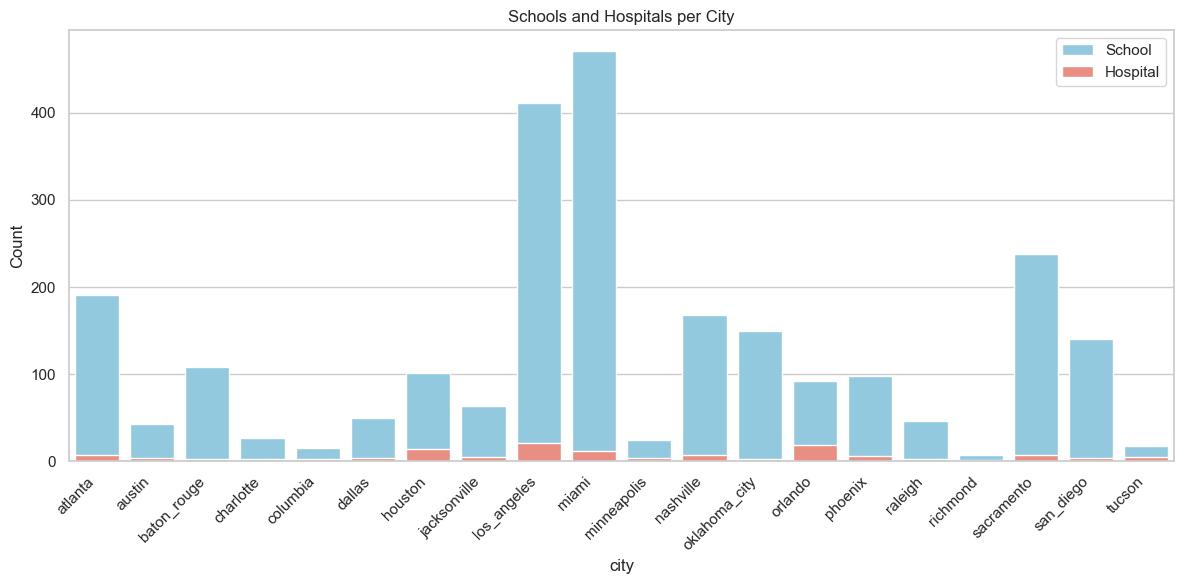

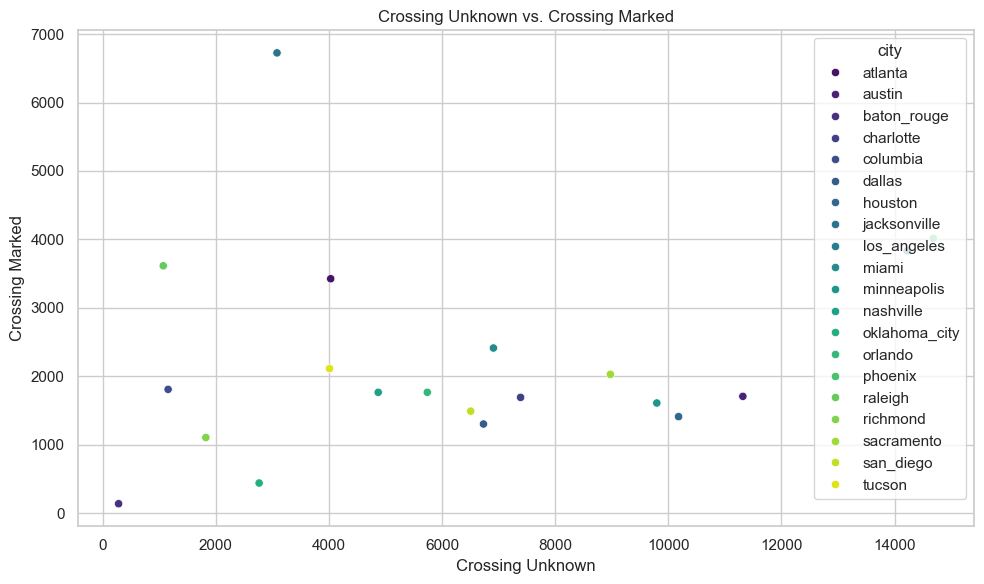

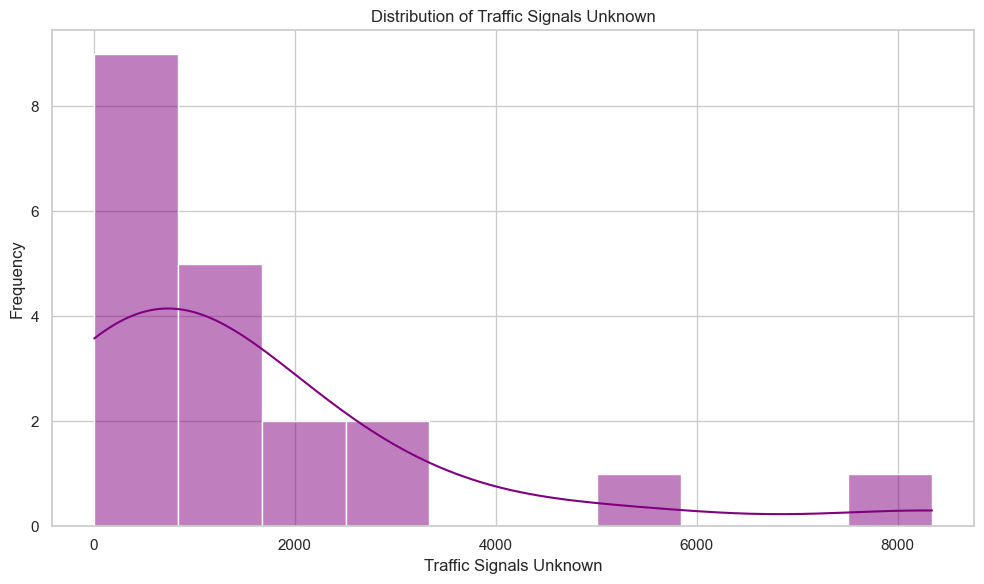

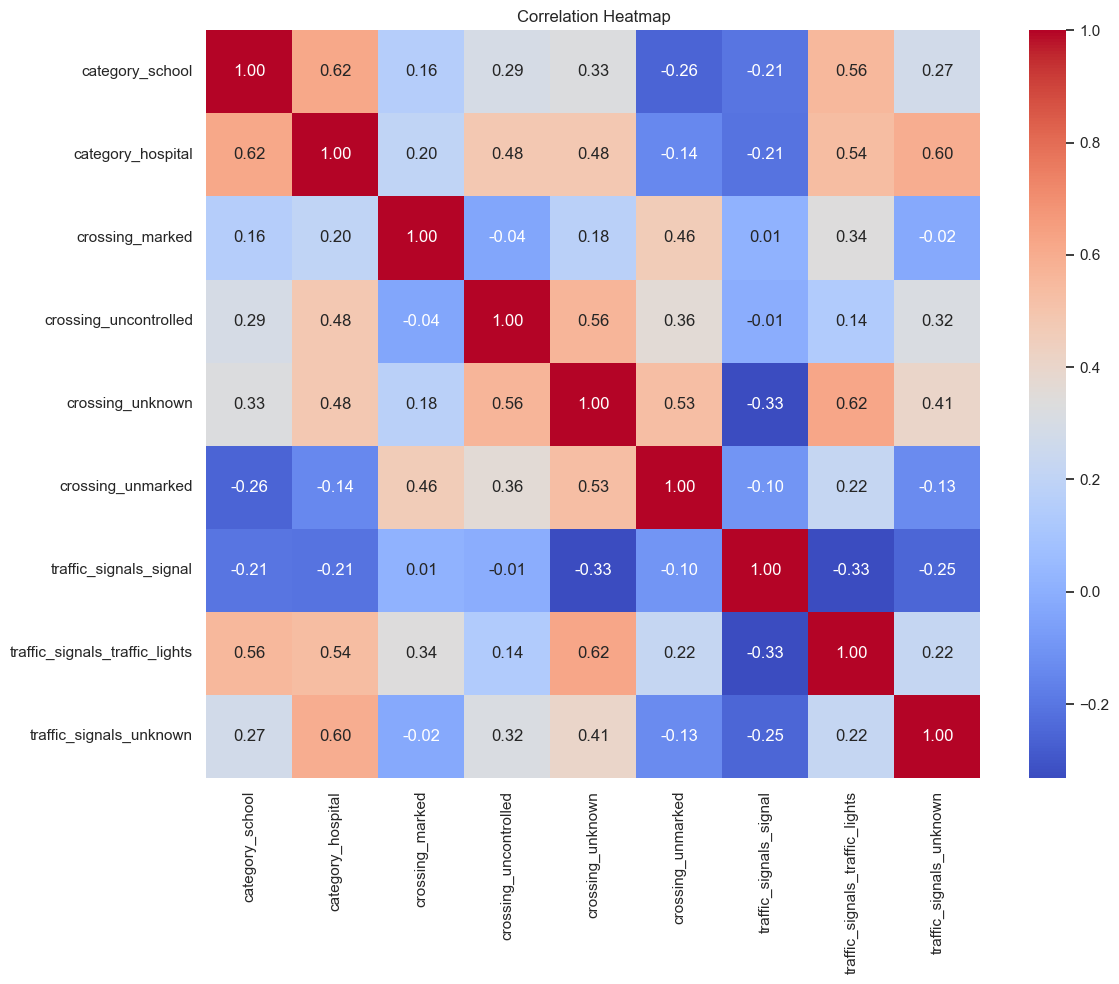

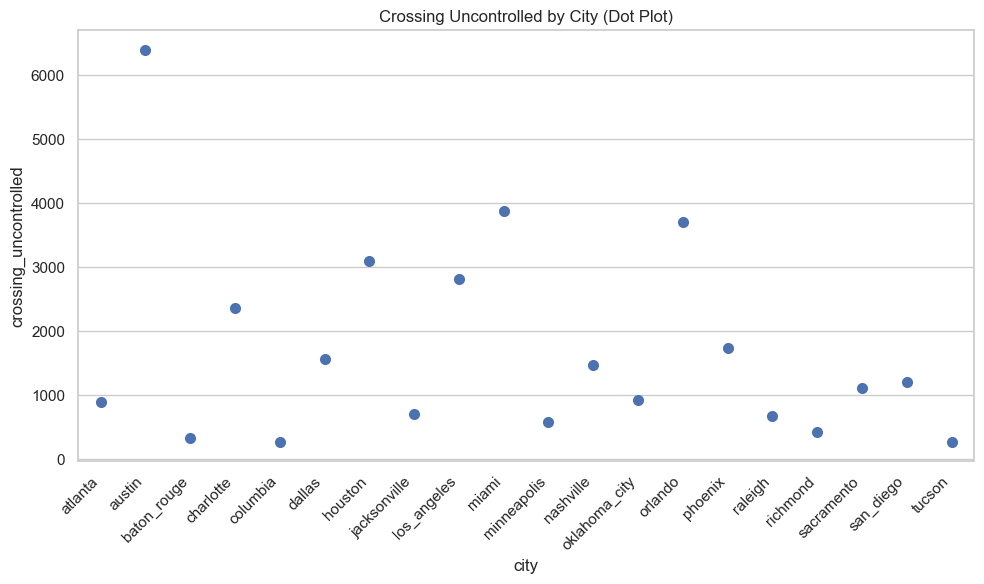

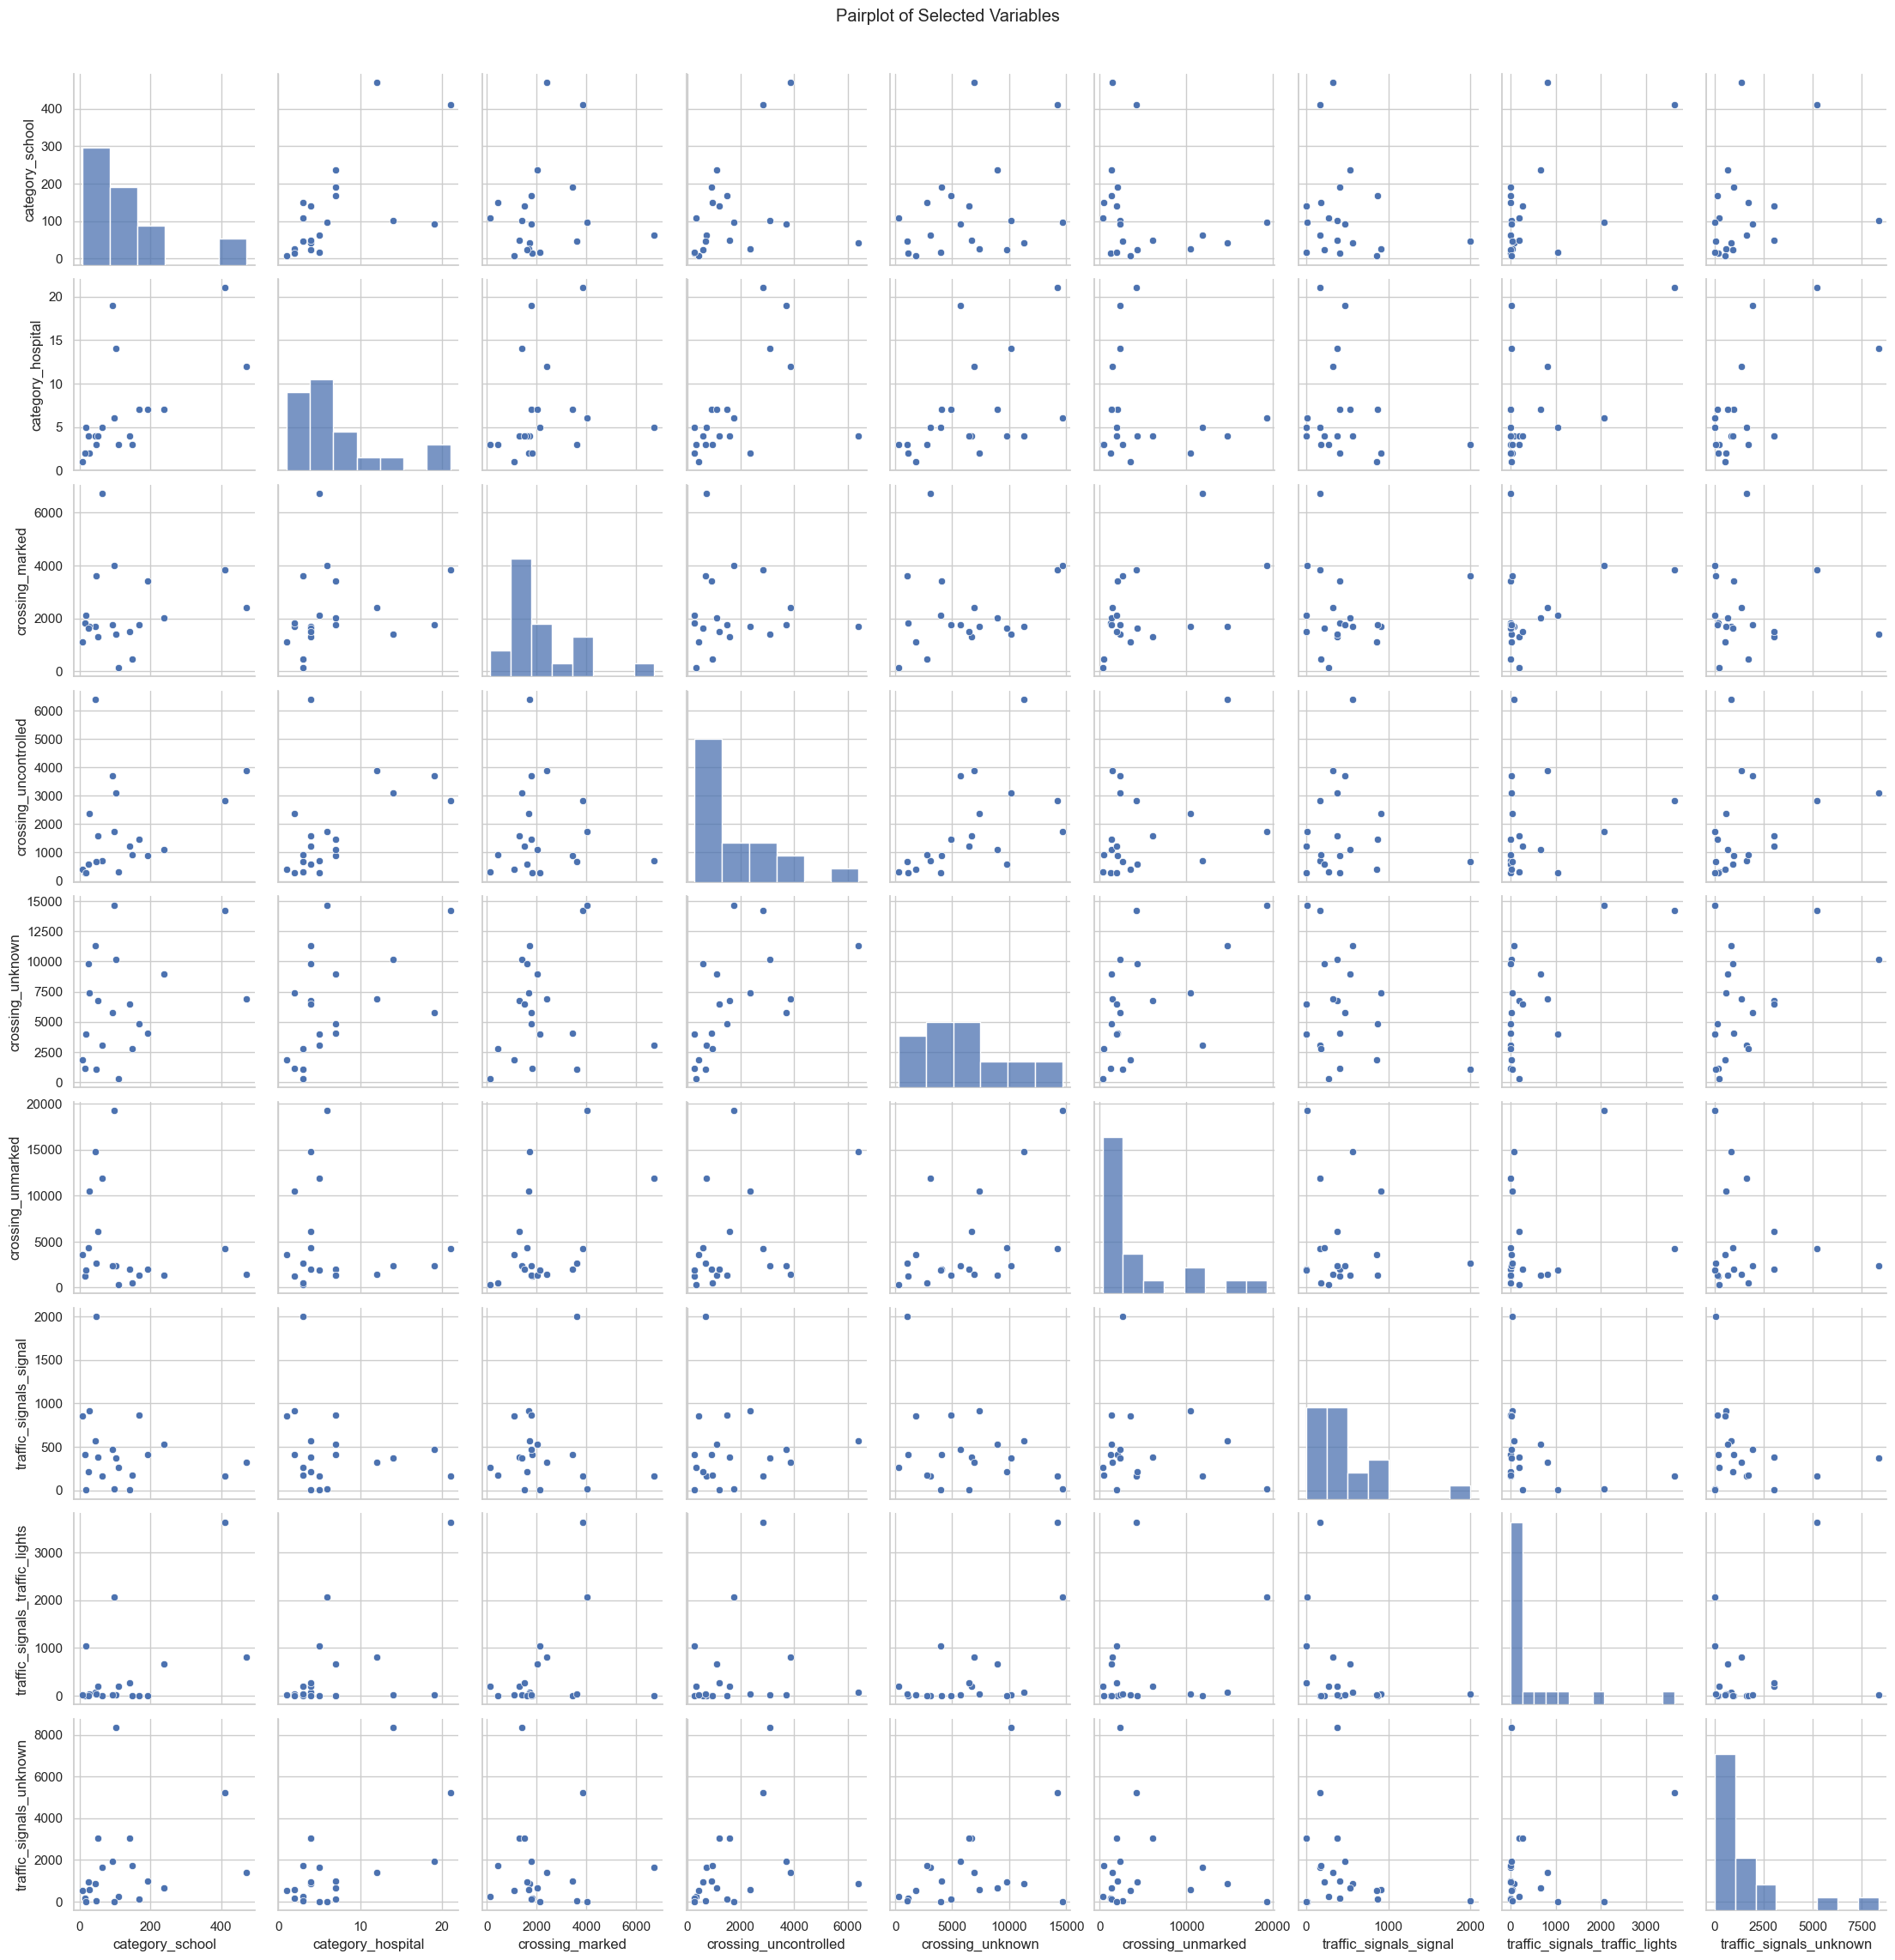

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/combined_city_summary_detailed.csv")

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x="city", y="category_school", color="skyblue", label="School")
sns.barplot(data=df, x="city", y="category_hospital", color="salmon", label="Hospital", ax=ax)
ax.set_xticklabels(df["city"], rotation=45, ha="right")
ax.set_title("Schools and Hospitals per City")
ax.set_ylabel("Count")
ax.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="crossing_unknown", y="crossing_marked", hue="city", palette="viridis")
plt.title("Crossing Unknown vs. Crossing Marked")
plt.xlabel("Crossing Unknown")
plt.ylabel("Crossing Marked")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="traffic_signals_unknown", bins=10, kde=True, color="purple")
plt.title("Distribution of Traffic Signals Unknown")
plt.xlabel("Traffic Signals Unknown")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
cols = [
    "category_school", "category_hospital", "crossing_marked", 
    "crossing_uncontrolled", "crossing_unknown", "crossing_unmarked", 
    "traffic_signals_signal", "traffic_signals_traffic_lights", 
    "traffic_signals_unknown"
]
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x="city", y="crossing_uncontrolled", jitter=True, size=8)
plt.xticks(rotation=45, ha="right")
plt.title("Crossing Uncontrolled by City (Dot Plot)")
plt.tight_layout()
plt.show()

sns.pairplot(df[cols])
plt.suptitle("Pairplot of Selected Variables", y=1.02)
plt.show()


### Observations

#### 1. **Schools and Hospitals per City**
- **Miami** and **Los Angeles** stand out with the highest number of schools.
- **Houston** and **Sacramento** also show strong infrastructure presence.
- Hospital counts are generally low in comparison, with most cities reporting fewer than 20.

#### 2. **Crossing Unknown vs. Crossing Marked**
- Cities like **Austin**, **Orlando**, and **Phoenix** show a large number of crossings marked as “unknown,” suggesting either incomplete tagging or diverse, unclassified designs.
- **Jacksonville** has a notably high number of clearly marked crossings.

#### 3. **Distribution of Traffic Signals Unknown**
- The majority of cities have relatively few “unknown” traffic signal types.
- **Houston**, **Los Angeles**, and **Phoenix** are outliers with much higher counts, indicating variability in tagging practices or broader infrastructure coverage.

#### 4. **Correlation Heatmap**
- A moderate positive correlation is observed between the number of **schools and hospitals**.
- **Uncontrolled** and **unknown** crossings show a strong positive relationship.
- **Traffic signal types** such as `traffic_lights` and `unknown` correlate with the presence of amenities, possibly reflecting areas with higher urban complexity.

#### 5. **Crossing Uncontrolled by City (Dot Plot)**
- **Austin** reports the highest number of uncontrolled pedestrian crossings, followed by **Miami** and **Phoenix**.
- **San Diego**, **Sacramento**, and **Charlotte** also present a considerable count, suggesting varying approaches to traffic design across municipalities.

---

These insights offer a foundation for comparing how cities structure their pedestrian and traffic infrastructure, and can guide future modeling efforts to assess the impact of urban design on traffic safety outcomes.

## Descriptive Statistics of OSM Features by City

### Overview

This table provides summary statistics (mean, standard deviation, min, max, and quartiles) for the main infrastructure variables extracted from OpenStreetMap across the 20 selected U.S. cities. The statistics help understand the general distribution and variability of urban features such as schools, hospitals, crossings, and traffic signals.

The analysis includes both simple amenities (like schools) and complex categories (like specific types of crossings or signals).

In [60]:
desc_stats = df.describe()
print("Descriptive Statistics:")
print(desc_stats)


Descriptive Statistics:
       category_hospital  category_school  crossing_combinaciones  \
count          20.000000        20.000000               20.000000   
mean            6.650000       122.950000               16.250000   
std             5.575086       126.452186               23.471988   
min             1.000000         7.000000                0.000000   
25%             3.000000        39.000000                1.750000   
50%             4.500000        95.000000                4.500000   
75%             7.000000       153.750000               21.500000   
max            21.000000       471.000000               91.000000   

       crossing_marked  crossing_uncontrolled  crossing_unknown  \
count        20.000000              20.000000         20.000000   
mean       2221.250000            1724.050000       6277.050000   
std        1484.052449            1575.806342       4230.543644   
min         140.000000             275.000000        282.000000   
25%        1472.000

### Observations

- **Schools** show high variability, with a mean of ~123 and a standard deviation of ~126, indicating large differences in how well cities are mapped or built.
- The number of **marked pedestrian crossings** varies widely (min = 140, max = 6725), with a median around 1767.
- **Unmarked** and **unknown** crossings have extremely high maximum values (up to 19,248 and 14,683 respectively), suggesting inconsistencies in OSM tagging or urban design differences.
- Most specialized **traffic signal types** (like `bridge`, `level_crossing`, `emergency`) are rare, often with medians of 0.
- **Pedestrian crossing signals** and **ramp meters** show highly skewed distributions, with only a few cities registering large counts (e.g., one city has 134 ramp meters).
- The average number of standard traffic signals (`signal`) and `traffic_lights` is similar (~456), but `traffic_lights` have a much wider range and higher standard deviation due to large counts in cities like Los Angeles.

These descriptive statistics provide a baseline for comparing infrastructure availability and consistency across cities and can support future correlation or clustering analyses.


## Key Insights from OSM Urban Infrastructure Data

### Pedestrian and Traffic Infrastructure Patterns Across Cities

- **Educational infrastructure** is highly variable: While cities like **Miami** and **Los Angeles** report over 400 schools, others like **Richmond** or **Tucson** have fewer than 20. This reflects differences in urban scale, mapping completeness, or actual density.

- **Pedestrian crossings** show striking differences in classification:
  - **Marked crossings** are common in cities like **Jacksonville**, but many other cities have thousands of crossings labeled as **"unknown"** or **"unmarked"**, particularly **Phoenix**, **Austin**, and **Charlotte**.
  - **Austin** stands out for having the highest number of **uncontrolled** crossings, which may indicate infrastructure gaps in pedestrian safety.

- **Traffic signal data** also varies:
  - Most cities have a modest number of signals classified as `signal`, but **Los Angeles** and **Phoenix** report exceptionally high numbers of `traffic_lights`.
  - Specialized signals (e.g., `emergency`, `bridge`, `ramp_meter`) are rare but appear in some cities like **Orlando**, **Los Angeles**, and **San Diego**, suggesting greater infrastructure complexity.

### Tagging Completeness and Data Quality

- Many features in the dataset are labeled as **"unknown"**, especially in the `crossing` and `traffic_signals` categories. This highlights inconsistencies in OSM tagging and underscores the need for cautious interpretation or additional cleaning steps.

- The **heatmap of correlations** reveals meaningful relationships:
  - Cities with more **schools** tend to also have more **hospitals**.
  - There is a strong correlation between **unknown** and **uncontrolled crossings**, suggesting these may be used interchangeably or reflect the same tagging ambiguities.

### Overall Implications

- The dataset reveals real structural differences in how cities implement and document urban infrastructure, which can significantly influence pedestrian and traffic safety outcomes.
- These insights provide a strong foundation for integrating geospatial context into accident prediction models or infrastructure risk assessments.
- The analysis also helps identify **under-mapped cities**, **infrastructure gaps**, or **inconsistent tagging practices** that could affect downstream modeling or urban planning efforts.
 ---
 ## Complementarity with Crash Dataset

### Overview

The current EDA focuses on OpenStreetMap (OSM) data extracted via the Overpass API, providing detailed information on urban infrastructure across 20 U.S. cities — including the presence and classification of **schools**, **hospitals**, **crossings**, and **traffic signals**. This data represents the **built environment context** where traffic accidents may occur.

In a future stage of the project, this OSM dataset is intended to be **merged with a crash-level dataset** that contains detailed information about traffic incidents in the United States. The crash dataset includes variables such as:

- **Environmental conditions**: weather, lighting, road surface condition
- **Crash characteristics**: type, severity, number of vehicles involved
- **Temporal data**: date, hour, day of the week, month
- **Location context**: intersection involvement, road type, alignment
- **Injuries**: total, fatal, incapacitating, non-incapacitating

### How the API Data Complements the Crash Data

By merging the crash dataset with OSM infrastructure data at the **city or geographic coordinate level**, we can:

- **Add spatial context** to each accident: e.g., Was it near a school, a hospital, a traffic signal, or a marked/unmarked crossing?
- **Enhance feature engineering** for modeling: e.g., Include binary or count variables like `num_schools_nearby`, `has_marked_crossing`, `signal_density`.
- **Identify infrastructure-related risk factors**: Analyze whether certain crash types or severities are more frequent in areas with specific infrastructure patterns.
- **Support spatial visualization**: Map accident hotspots against OSM features to detect high-risk urban zones.

### Future Integration Plan

The current OSM dataset provides detailed information on urban infrastructure (schools, hospitals, crossings, and traffic signals) across 20 major U.S. cities. However, the crash dataset available at this stage *does not include geographic coordinates or city identifiers*, which prevents direct spatial merging.

Despite this limitation, there are still multiple viable strategies to integrate the OSM data meaningfully in future phases:

#### 1. Enrichment via Temporal Features
Since the crash dataset contains crash_hour, crash_day_of_week, and crash_month, it's possible to create summary tables from the OSM context (e.g., average infrastructure density by time segment) and merge them based on these temporal features. This can help analyze whether certain time frames correlate with infrastructure-related risk factors.

#### 2. Feature Aggregation at Dataset Level
If individual merging is not feasible, the OSM data can still provide high-level urban context by generating external features, such as:

- avg_schools_per_city
- pct_crossings_marked
- signal_to_crossing_ratio
- total_traffic_signals

These features can serve as external variables in statistical models or to contextualize the broader environment in which the accidents occurred.

#### 3. Profiling Accident Data Using OSM Clusters
Cities from the OSM dataset can be clustered into categories based on infrastructure density (e.g., HighInfra, MidInfra, LowInfra). Even without precise location, crash data entries can be *labeled manually or probabilistically* with one of these infrastructure profiles, enabling comparative analysis by urban context.

#### 4. Hypothesis-Driven Comparative Analysis
Alternatively, the OSM data can be used independently to *formulate and test hypotheses*, such as:
> "Cities with a higher percentage of unmarked crossings tend to report more rear-end collisions."

While the crash dataset lacks geographic specificity, such comparisons can still guide interpretations, especially when aligning patterns observed in the OSM data with accident types or severities.